In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./MNIST_DATA", one_hot=True)

%matplotlib inline

Extracting ./MNIST_DATA/train-images-idx3-ubyte.gz
Extracting ./MNIST_DATA/train-labels-idx1-ubyte.gz
Extracting ./MNIST_DATA/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_DATA/t10k-labels-idx1-ubyte.gz


In [3]:
trainimgs = mnist.train.images
trainlabels = mnist.train.labels
testimgs = mnist.test.images
testlabels = mnist.test.labels 

ntrain = trainimgs.shape[0]
ntest = testimgs.shape[0]
dim = trainimgs.shape[1]
nclasses = trainlabels.shape[1]
print( "Train Images: ", trainimgs.shape)
print( "Train Labels  ", trainlabels.shape)
print( "Test Images:  " , testimgs.shape)
print( "Test Labels:  ", testlabels.shape)

Train Images:  (55000, 784)
Train Labels   (55000, 10)
Test Images:   (10000, 784)
Test Labels:   (10000, 10)


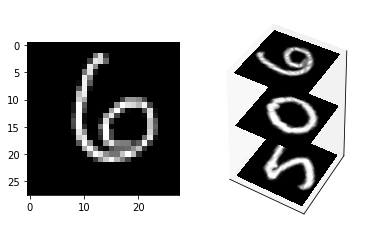

Sample: 100 - Class: [6] - Label Vector: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] 
Sample: 101 - Class: [0] - Label Vector: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
Sample: 102 - Class: [5] - Label Vector: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 


In [5]:
samplesIdx = [100, 101, 102]  #<-- Y您可以在这里更改这些数字以查看其他样本

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()

ax1 = fig.add_subplot(121)
ax1.imshow(testimgs[samplesIdx[0]].reshape([28,28]), cmap='gray')

xx, yy = np.meshgrid(np.linspace(0,28,28), np.linspace(0,28,28))
X =  xx ; Y =  yy
Z =  100*np.ones(X.shape)

img = testimgs[77].reshape([28,28])
ax = fig.add_subplot(122, projection='3d')
ax.set_zlim((0,200))


offset=200
for i in samplesIdx:
    img = testimgs[i].reshape([28,28]).transpose()
    ax.contourf(X, Y, img, 200, zdir='z', offset=offset, cmap="gray")
    offset -= 100

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

plt.show()

for i in samplesIdx:
    print( "Sample: {0} - Class: {1} - Label Vector: {2} "
          .format(i, np.nonzero(testlabels[i])[0], testlabels[i]))

In [6]:
# 一个可以将 28∗28 维的输入转化为 128 维隐藏层的输入层
# 一个中间循环神经网络（LSTM） 一个可以将 128 维的LSTM输出转化为 10 维代表类标签输出的输出层
n_input = 28 # 输出MNIST数据 (img shape: 28*28)
n_steps = 28 # 时间步长
n_hidden = 128 # 隐藏层的特征
n_classes = 10 # MNIST全部的类(0-9 digits)

learning_rate = 0.001
training_iters = 10000
batch_size = 100
display_step = 1000

In [7]:
# 当前数据输入形状: (batch_size, n_steps, n_input) [100x28x28]
# batch_size就是每个batch有多少条数据，n_steps就是循环神经网络要记忆多少步，n_input是embedding的大小
x = tf.placeholder(dtype="float", shape=[None, n_steps, n_input], name="x")
y = tf.placeholder(dtype="float", shape=[None, n_classes], name="y")

weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [8]:
# 这个LSTM有128个节点，虽然只有一层，但是这128个节点有一个内循环
lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)

In [9]:
#  输入x（28×28），输出128个节点的h（out），以及对应的隐状态（state ）
outputs, states = tf.nn.dynamic_rnn(lstm_cell, inputs=x, dtype=tf.float32)

In [10]:
output = tf.reshape(tf.split(outputs, 28, axis=1, num=None, name='split')[-1],[-1,128])
pred = tf.matmul(output, weights['out']) + biases['out']

In [12]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=pred ))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [14]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    step = 1
    # 保持循环，直到最大次数迭代
    while step * batch_size < training_iters:

        # 我们将以batch_x的形式读取一批100张[100 x 784]图像
        # batch_y  是一个[100x10]的矩阵
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        
        # 我们将图像的每一行视为一个序列
        # 重塑数据以获得28个元素的28个序列，因此，batxh_x是[100x28x28]
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
    

        # 运行优化操作
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        
        
        if step * batch_size % display_step == 0:
            # 计算批次精度
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            # 计算批量损失
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
            print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1
    print("Optimization Finished!")

    # 计算128个mnist测试图像的准确性
    test_len = 128
    test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
    test_label = mnist.test.labels[:test_len]
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: test_data, y: test_label}))
sess.close()

Iter 10000, Minibatch Loss= 0.457479, Training Accuracy= 0.86000
Iter 20000, Minibatch Loss= 0.344754, Training Accuracy= 0.86000
Iter 30000, Minibatch Loss= 0.132071, Training Accuracy= 0.97000
Iter 40000, Minibatch Loss= 0.174254, Training Accuracy= 0.94000
Iter 50000, Minibatch Loss= 0.176646, Training Accuracy= 0.93000
Iter 60000, Minibatch Loss= 0.217799, Training Accuracy= 0.93000
Iter 70000, Minibatch Loss= 0.223055, Training Accuracy= 0.94000
Iter 80000, Minibatch Loss= 0.099500, Training Accuracy= 0.96000
Iter 90000, Minibatch Loss= 0.046564, Training Accuracy= 0.99000
Optimization Finished!
Testing Accuracy: 0.9921875


In [15]:
help(tf.nn.dynamic_rnn)

Help on function dynamic_rnn in module tensorflow.python.ops.rnn:

dynamic_rnn(cell, inputs, sequence_length=None, initial_state=None, dtype=None, parallel_iterations=None, swap_memory=False, time_major=False, scope=None)
    Creates a recurrent neural network specified by RNNCell `cell`.
    
    Performs fully dynamic unrolling of `inputs`.
    
    Example:
    
    ```python
    # create a BasicRNNCell
    rnn_cell = tf.nn.rnn_cell.BasicRNNCell(hidden_size)
    
    # 'outputs' is a tensor of shape [batch_size, max_time, cell_state_size]
    
    # defining initial state
    initial_state = rnn_cell.zero_state(batch_size, dtype=tf.float32)
    
    # 'state' is a tensor of shape [batch_size, cell_state_size]
    outputs, state = tf.nn.dynamic_rnn(rnn_cell, input_data,
                                       initial_state=initial_state,
                                       dtype=tf.float32)
    ```
    
    ```python
    # create 2 LSTMCells
    rnn_layers = [tf.nn.rnn_cell.LSTMCel

In [16]:
help(tf.split)

Help on function split in module tensorflow.python.ops.array_ops:

split(value, num_or_size_splits, axis=0, num=None, name='split')
    Splits a tensor into sub tensors.
    
    If `num_or_size_splits` is an integer type, `num_split`, then splits `value`
    along dimension `axis` into `num_split` smaller tensors.
    Requires that `num_split` evenly divides `value.shape[axis]`.
    
    If `num_or_size_splits` is not an integer type, it is presumed to be a Tensor
    `size_splits`, then splits `value` into `len(size_splits)` pieces. The shape
    of the `i`-th piece has the same size as the `value` except along dimension
    `axis` where the size is `size_splits[i]`.
    
    For example:
    
    ```python
    # 'value' is a tensor with shape [5, 30]
    # Split 'value' into 3 tensors with sizes [4, 15, 11] along dimension 1
    split0, split1, split2 = tf.split(value, [4, 15, 11], 1)
    tf.shape(split0)  # [5, 4]
    tf.shape(split1)  # [5, 15]
    tf.shape(split2)  # [5, 11]
    